In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Swain v Alabama

Only go over high-level details for now, will dive into more details later.

What is the probability of getting the actual panel with 8/100 black jurors?

1. Start with the distributions of eligible jurors and the actual panel.
2. Draw panels at random from the eligible jurors.
3. See if my actual panel is likely.

### Step 1: Distributions of population and sample

In [2]:
swain = Table().with_columns(
    'Ethnicity', make_array('Black', 'Other'),
    'Eligible', make_array(0.26, 0.74),
    'Panel', make_array(0.08, 0.92)
)

swain.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panel
Black,26%,8%
Other,74%,92%


### Step 2: Draw panels at random from population

In [3]:
population_distribution = swain.column('Eligible')
panel_size = 100

def random_jury_panel():
    panel = swain.select(0).sample(panel_size, weights=swain.column('Eligible'))
    counts = panel.group(0)
    sample_proportions = counts.select(0).with_column('Random', counts.column(1) / panel_size)
    sample_proportions.set_format(1, PercentFormatter(0))
    return swain.join('Ethnicity', sample_proportions)

random_jury_panel()

Ethnicity,Eligible,Panel,Random
Black,26%,8%,30%
Other,74%,92%,70%


### Step 3: See if sample panel is unlikely

In [4]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

table_tvd(swain, 'Eligible', 'Panel')

0.18000000000000002

In [5]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = random_jury_panel()
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results

TVD between the population & a random sample
0.1
0.03
0.02
0.09
0.04
0.06
0.06
0.03
0.03
0.01


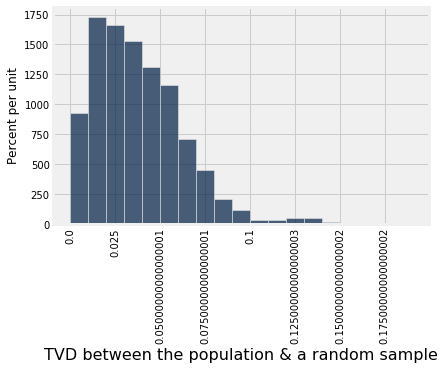

In [6]:
results.hist(bins=np.arange(0, 0.2, 0.01))

In [7]:
table_tvd(swain, 'Eligible', 'Panel')

0.18000000000000002

## Alameda County Juries

- That was in the 1960s. What about now?
- American Civil Liberties Union (ACLU) released report on Racial and Ethnic Disparities in Alameda County
- Interviewed panels of 11 different felony trials in 2009 and 2010

### Step 1: Distributions of population and sample

In [8]:
# Data from an ACLU 2010 report
# Racial and Ethnic Disparities in Alameda County Jury Pools
# https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf

panels = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

panels.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


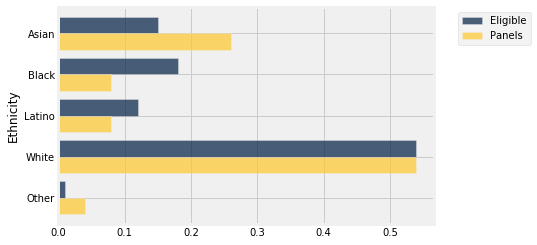

In [9]:
panels.barh(0)

### Step 2: Draw panels at random from population

In [10]:
panel_seze = 1453

In [11]:
panels.select('Ethnicity')

Ethnicity
Asian
Black
Latino
White
Other


In [12]:
panels.select('Ethnicity').sample(10000).group(0)

Ethnicity,count
Asian,2031
Black,1980
Latino,1969
Other,1986
White,2034


In [13]:
panels.column('Eligible')

array([0.15, 0.18, 0.12, 0.54, 0.01])

In [14]:
panels.select('Ethnicity').sample(10000, weights=panels.column('Eligible')).group(0)

Ethnicity,count
Asian,1469
Black,1816
Latino,1228
Other,112
White,5375


But there's an easier way:

In [15]:
sample = proportions_from_distribution(panels, 'Eligible', 1453)
sample

Ethnicity,Eligible,Panels,Random Sample
Asian,15%,26%,0.151411
Black,18%,8%,0.16724
Latino,12%,8%,0.114246
White,54%,54%,0.554714
Other,1%,4%,0.0123882


In [16]:
sample_1 = sample.set_format([1, 2], PercentFormatter(0))
sample_1

Ethnicity,Eligible,Panels,Random Sample
Asian,15%,26%,0.151411
Black,18%,8%,0.16724
Latino,12%,8%,0.114246
White,54%,54%,0.554714
Other,1%,4%,0.0123882


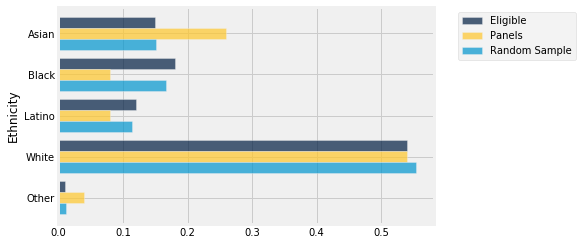

In [17]:
sample.barh('Ethnicity')

back to slide

### Step 3: See if sample panel is unlikely

In [18]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

table_tvd(panels, 'Eligible', 'Panels')

0.14

In [19]:
table_tvd(sample_1, 'Eligible', 'Random Sample')

0.01851342050929109

In [20]:
table_tvd(sample_1, 'Eligible', 'Panels')

0.14

**Repeated trials**

In [21]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = proportions_from_distribution(panels, 'Eligible', 1453,)
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random Sample'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results

TVD between the population & a random sample
0.0072746
0.0210186
0.0109635
0.0227598
0.0132897
0.0182312
0.0103923
0.0121266
0.00989677
0.0275981


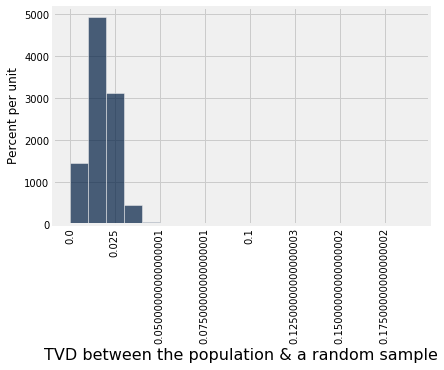

In [22]:
results.hist(0, bins=np.arange(0, 0.2, 0.01))

In [23]:
def hist_n_samples(tbl, n, bins=None):
    '''Draws histogram of first n rows of first column in tbl.'''
    tbl.take(np.arange(n)).hist(bins=bins)
    plt.ylim(0, 50)
    plt.show()

In [24]:
_ = interact(hist_n_samples, tbl=fixed(results), n=(1, 1000, 10), bins=fixed(np.arange(0, 0.2, 0.01)))

interactive(children=(IntSlider(value=491, description='n', max=1000, min=1, step=10), Output()), _dom_classes…

Original panel TVD:

In [25]:
table_tvd(panels, 'Eligible', 'Panels')

0.14

## How do you think our analysis would change if the jury panels had only 50 people?

In [26]:
sample_50 = proportions_from_distribution(panels, 'Eligible', 50)
sample_50.set_format([1, 2, 3], PercentFormatter(0))

Ethnicity,Eligible,Panels,Random Sample
Asian,15%,26%,20%
Black,18%,8%,22%
Latino,12%,8%,14%
White,54%,54%,44%
Other,1%,4%,0%


In [27]:
tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = proportions_from_distribution(panels, 'Eligible', 50)
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random Sample'))

results_50 = Table().with_column('TVD between the population & a random sample', tvds)
results_50

TVD between the population & a random sample
0.05
0.08
0.11
0.14
0.07
0.16
0.06
0.04
0.03
0.1


In [28]:
_ = interact(hist_n_samples, tbl=fixed(results_50), n=(1, 1000, 10), bins=fixed(np.arange(0, 0.2, 0.01)))

interactive(children=(IntSlider(value=491, description='n', max=1000, min=1, step=10), Output()), _dom_classes…

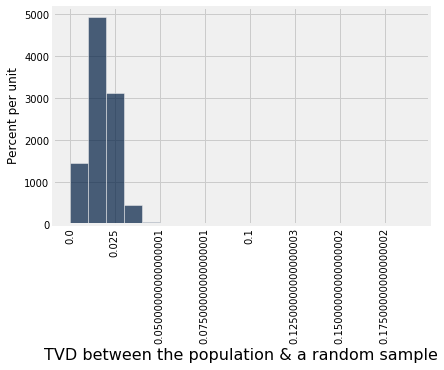

In [29]:
results.hist(bins=np.arange(0, 0.2, 0.01))

## Addendum: Alameda County Race & Ethnicity Distribution

In [30]:
# According to the 2010 Census, https://www.census.gov/2010census/popmap/

alameda_race = Table(['Race', 'Population']).with_rows([
    ['White', 649122],
    ['African American', 190451],
    ['Asian', 394560],
    ['AIAN', 9799],
    ['NHPI', 12802],
    ['Some Other Race', 162540],
    ['Two or more Races', 90997],
])

alameda_race.set_format(1, DistributionFormatter).show()

alameda_ethnicity = Table(['Ethnicity', 'Population']).with_rows([
    ['Hispanic or Latino', 339889],
    ['Not Hispanic or Latino', 1170382],
])

alameda_ethnicity.set_format(1, DistributionFormatter).show()

Race,Population
White,42.98%
African American,12.61%
Asian,26.13%
AIAN,0.65%
NHPI,0.85%
Some Other Race,10.76%
Two or more Races,6.03%


Ethnicity,Population
Hispanic or Latino,22.51%
Not Hispanic or Latino,77.49%


In [31]:
panels

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


All analysis is only as good as the data you start with.

## Hypothesis Testing

## Pea Flowers

In [32]:
null = make_array('Purple', 'Purple', 'Purple', 'White')
null

array(['Purple', 'Purple', 'Purple', 'White'], dtype='<U6')

In [33]:
sample = np.random.choice(null, 10)
sample

array(['White', 'Purple', 'Purple', 'Purple', 'Purple', 'Purple',
       'Purple', 'Purple', 'Purple', 'White'], dtype='<U6')

In [34]:
proportion_purple = np.count_nonzero(sample == 'Purple') / len(sample)
proportion_purple

0.8

In [35]:
proportion_purple - 0.75

0.050000000000000044

In [36]:
sample = np.random.choice(null, 10)
proportion_purple = np.count_nonzero(sample == 'Purple') / len(sample)
abs(proportion_purple - 0.75)

0.050000000000000044

In [37]:
def test_stat(sample):
    proportion_purple = np.count_nonzero(sample == 'Purple') / len(sample)
    return abs(proportion_purple - 0.75)

total_plants = 929
observed = 705 / 929 # 705 / 929 were purple
observed_statistic = abs(observed - 0.75) 

In [38]:
test_stat(make_array('Purple'))

0.25

In [39]:
# Simulating the test statistic under the null hypothesis
repetitions = 5000
sampled_stats = make_array()

for i in np.arange(repetitions):
    new_sample = np.random.choice(null, total_plants)
    sampled_stats = np.append(sampled_stats, test_stat(new_sample))
    
sampled_stats

array([0.01426265, 0.00296017, 0.01910657, ..., 0.01264801, 0.00511302,
       0.00565124])

In [40]:
null_dist = Table().with_column('Null distribution', sampled_stats)
null_dist

Null distribution
0.0142626
0.00296017
0.0191066
0.012648
0.0083423
0.0196448
0.020183
0.0158773
0.00296017
0.00888052


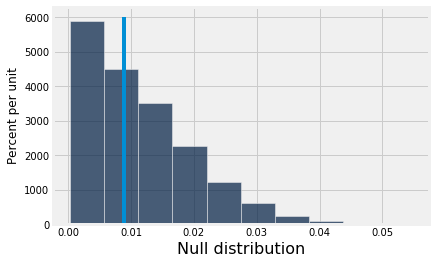

In [41]:
null_dist.hist()
_ = plt.plot([observed_statistic, observed_statistic], [0, 60])

## P-value

In [42]:
# The P-value (an approximation based on the simulation)
np.count_nonzero(sampled_stats >= observed_statistic)/len(sampled_stats)

0.5552

In [43]:
mahdi_tried_again = 0.03
mahdi_tried_again

0.03

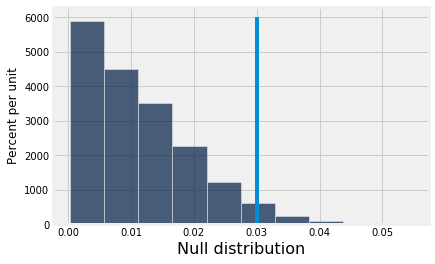

In [44]:
null_dist.hist()
_ = plt.plot([mahdi_tried_again, mahdi_tried_again], [0, 60])

In [45]:
# The P-value (an approximation based on the simulation)
np.count_nonzero(sampled_stats >= mahdi_tried_again)/repetitions

0.0362

## Discussion Question: What Happens If...

I remove the absolute value from the test statistic?

In [46]:
def test_stat(sample):
    prop_purple = (np.count_nonzero(sample == 'Purple')
                   / len(sample)
                   - 0.75)
    return prop_purple

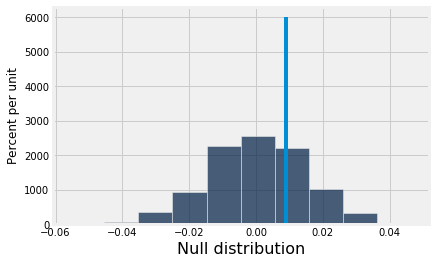

In [47]:
repetitions = 5000
sample_stats = make_array()

for i in np.arange(repetitions):
    stat = test_stat(np.random.choice(null, total_plants))
    sample_stats = np.append(sample_stats, stat)
    
null_dist = Table().with_columns('Null distribution', sample_stats)
null_dist.hist()
_ = plt.plot([observed_statistic, observed_statistic], [0, 60])

In [48]:
# compute the p-value
np.count_nonzero(sample_stats >= observed_statistic) / len(sample_stats)

# the previous p-value was around 0.54. Why is it different this time?

0.2874